In [2]:
# !pip install --quiet optuna
# !pip install --quiet stellargraph

In [3]:
import os
import optuna
from optuna.trial import TrialState

In [4]:
import pandas as pd
import numpy as np
import torch
import random
import math
import torch.optim as optim

In [5]:
from torch.utils.data import DataLoader, TensorDataset

# Data prep

In [6]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3
pre_len = 1

#adjacency matrix
grid_points = pd.read_csv('../Data/grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [7]:
def data_preparation(datafile):
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # only PM2_5
    df = df[['dateTime','lat','long','pm2_5']]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=360)] 

    # only PM2_5
#     df = df[['dateTime','lat_grid','long_grid','pm2_5
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
    columns = df.columns
#     df = df[columns[2:]]
    df = df.fillna(0)
    
    return df

In [8]:
df = data_preparation('../PM Datasets/2020-12-01_all.csv')

In [9]:
df

dateTime                  360         540         720         900   \
lat_grid long_grid                                                   
0        22         274.869242  275.605369  185.320702  142.292380   
1        21         277.657143  290.829787  191.355140  133.500000   
         22         274.326007  286.357724  210.973510  143.156716   
2        21         276.337884  294.913357  194.714286  130.401198   
         22         309.000000    0.000000    0.000000  120.750000   
...                        ...         ...         ...         ...   
18       20         319.370370  335.133333  312.354839  189.211268   
         23         293.303030  305.217391    0.000000  203.821429   
         24         309.564706  319.508772    0.000000  194.931624   
19       19         338.242424  350.683333  294.000000  179.868421   
         20         326.805970  324.847162  268.331370  197.803704   

dateTime                  1080        1260  
lat_grid long_grid                          
0        22         210.565693  303.773973  
1        21         184.521739  309.384615  
         22         195.157143  279.916667  
2        21         190.013514  311.555556  
         22           0.000000    0.000000  
...                        ...         ...  
18       20         182.400000  504.166667  
         23           0.000000    0.000000  
         24           0.000000    0.000000  
19       19         208.177778    0.000000  
         20         212.255319    0.000000  

[130 rows x 6 columns]

In [10]:
def train_test_split(df, grid_points_indices, train_size):
    # random.seed(10)
    time_len = df.shape[1]
    train_size = int(time_len * train_size) 
    train_data = df.iloc[:, :train_size]
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)
    test_data = df.iloc[:, train_size:]
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [11]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [12]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [13]:
def prepare_train_data(df, grid_points_indices, train_size = 0.8):
    train_data, test_data = train_test_split(df, grid_points_indices, train_size)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)
    train_scaled, test_scaled = scale_data(train_data, test_data)
    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, pre_len, train_scaled, test_scaled
    )
    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data

# Training

In [14]:
def my_loss(y_true, y_pred):
    loss = torch.mean((y_pred[y_true>0]-y_true[y_true>0])**2)
    return loss

In [15]:
def eval_model(model, testX, testY):
    output = model(torch.Tensor(testX))
    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)
    ## Rescale model predicted values
    test_output = np.array((output.detach().numpy() * (max_pm - min_pm)) + min_pm)
    # # Masked predicted values\
    mask_test = torch.sign(torch.Tensor(testY))
    test_output = torch.Tensor(test_output)*(mask_test)
    test_mse = my_loss(torch.Tensor(test_true), torch.Tensor(test_output))
    test_rmse = torch.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [16]:
def get_out_df(train_rmse, validation_rmse):
    max_pm = train_data.max()
    min_pm = train_data.min()
    scale_factor = max_pm - min_pm
    df = pd.DataFrame()
    df['Mean Train loss'] = [sum(train_rmse)*scale_factor/len(train_rmse)]
    df['Last Train loss'] = [train_rmse[-1]*scale_factor]
    df['Mean Test loss'] = [sum(validation_rmse)*scale_factor/len(validation_rmse)]
    df['Last Test loss'] = [validation_rmse[-1]*scale_factor]
    # df['Train time callbacks'] = [sum(cb.logs)]
    return df

In [17]:
def plot_predictions(test_output, test_true, save_path=None):
    ##all test result visualization
    fig = plt.figure(figsize=(15, 8))
    # test_output, test_true = eval(model, testX, testY )
    a_pred = test_output[test_true>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("test points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Initialize The Model

In [19]:
df = data_preparation('../dataset/Dec/2020-12-1_all.csv')
for i in range(2, 8):
    datafile = '../dataset/Dec/2020-12-'
    datafile +=  str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)

In [20]:
df.head()

dateTime                  360         540         720         900   \
lat_grid long_grid                                                   
0        22         276.161812  275.351426  208.073770  140.052632   
1        20           0.000000    0.000000    0.000000    0.000000   
         21         278.000000  301.393939  196.307692  130.140000   
         22         273.241379  281.432432  203.779661  140.363636   
         23           0.000000    0.000000    0.000000    0.000000   

dateTime                  1080    1260        360         540         720   \
lat_grid long_grid                                                           
0        22         201.723881  302.28  297.647059  254.285714  153.757812   
1        20           0.000000    0.00    0.000000    0.000000    0.000000   
         21         185.382353  308.75    0.000000    0.000000  136.357143   
         22         188.000000  284.40    0.000000    0.000000  169.775510   
         23           0.000000    0.00    0.000000    0.000000    0.000000   

dateTime                  900   ...        720         900         1080  \
lat_grid long_grid              ...                                       
0        22         124.133333  ...  226.688025  131.059418  214.468085   
1        20           0.000000  ...    0.000000    0.000000    0.000000   
         21           0.000000  ...  230.888889  103.857143  211.500000   
         22           0.000000  ...  253.873016   91.536649  124.181818   
         23           0.000000  ...    0.000000    0.000000    0.000000   

dateTime                  1260        360         540         720   \
lat_grid long_grid                                                   
0        22         244.442159  336.659274  303.189607  199.727273   
1        20           0.000000    0.000000    0.000000    0.000000   
         21         279.714286  350.055556  307.000000  220.076923   
         22         253.390244  352.049587  301.425532  199.750000   
         23           0.000000    0.000000    0.000000  267.200000   

dateTime                  900         1080        1260  
lat_grid long_grid                                      
0        22         165.345331  233.682670  272.544699  
1        20           0.000000    0.000000    0.000000  
         21         167.058824  230.776119  263.291139  
         22         171.651515  213.301205  278.990909  
         23           0.000000    0.000000    0.000000  

[5 rows x 42 columns]

In [21]:
df.shape

(190, 42)

In [22]:
trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.86)

Train data:  (270, 36)
Test data:  (270, 6)
(33, 270, 3)
(33, 270)
(3, 270, 3)
(3, 270)


In [23]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(33, 270, 3) (33, 270) (3, 270, 3) (3, 270)


In [24]:
trainX[0].shape, trainY[0].shape, trainX.shape, trainY.shape

((270, 3), (270,), (33, 270, 3), (33, 270))

In [25]:
from gcn_lstm import GCN_LSTM
import numpy as np
import torch
adj = adj.astype(np.float32)
model=GCN_LSTM(torch.from_numpy(adj), grid_size = 270, seq_len = 3, gc_sizes = [4, 4], lstm_sizes = [4])
optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-05)

In [26]:
for param in model.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([270, 4])
<class 'torch.nn.parameter.Parameter'> torch.Size([270])


In [27]:

def train_model(model, optimizer, trainX, trainY, testX, testY, n_epochs, batch_size):
    # convert all data to tensor
    trainX = torch.from_numpy(trainX.astype(np.float32))
    trainY = torch.from_numpy(trainY.astype(np.float32))
    testX = torch.from_numpy(testX.astype(np.float32))
    testY = torch.from_numpy(testY.astype(np.float32))
    
    trainDs = TensorDataset(trainX, trainY)
    testDs = TensorDataset(testX, testY)
    trainLoader = DataLoader(trainDs, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(testDs, batch_size=batch_size, shuffle=False)

    train_mse, train_rmse, validation_mse, validation_rmse=[], [], [], []
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        for _, (inputs, targets) in enumerate(trainLoader):
            model.train()
            outputs = model(inputs)
            loss = my_loss(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(inputs)
        
        with torch.no_grad():
            for _, (inputs, targets) in enumerate(testLoader):
                model.eval()
                outputs = model(inputs)
                loss = my_loss(outputs, targets)
                valid_loss += loss.item()*len(inputs)

        train_loss /= len(trainX)
        valid_loss /= len(testX)
        train_mse.append(train_loss)
        validation_mse.append(valid_loss)
        train_rmse.append(math.sqrt(train_loss))
        validation_rmse.append(math.sqrt(valid_loss))

        if((epoch+1)%10==0):
            print(f'Epoch {epoch+1} \t Train Loss: ', {train_loss}, 'Valid Loss: ', {valid_loss})

    return train_mse, train_rmse, validation_mse, validation_rmse

Epoch 10 	 Train Loss:  {0.020484173783298695} Valid Loss:  {0.01437216904014349}
Epoch 20 	 Train Loss:  {0.016690669468406475} Valid Loss:  {0.013021789491176605}
Epoch 30 	 Train Loss:  {0.01655417299744758} Valid Loss:  {0.012961288914084435}
Epoch 40 	 Train Loss:  {0.015296964144164866} Valid Loss:  {0.01279233768582344}
Epoch 50 	 Train Loss:  {0.015545917195126865} Valid Loss:  {0.012649983167648315}
Epoch 60 	 Train Loss:  {0.01549618270699725} Valid Loss:  {0.013060828670859337}
Epoch 70 	 Train Loss:  {0.01547951629441796} Valid Loss:  {0.012463351711630821}
Epoch 80 	 Train Loss:  {0.015109130012040789} Valid Loss:  {0.01259293407201767}
Epoch 90 	 Train Loss:  {0.015110044457921476} Valid Loss:  {0.012399704195559025}
Epoch 100 	 Train Loss:  {0.015187402453386423} Valid Loss:  {0.012481310404837132}
Epoch 110 	 Train Loss:  {0.015348195493447058} Valid Loss:  {0.01286329422146082}
Epoch 120 	 Train Loss:  {0.015304150652479042} Valid Loss:  {0.01261412538588047}
Epoch 130

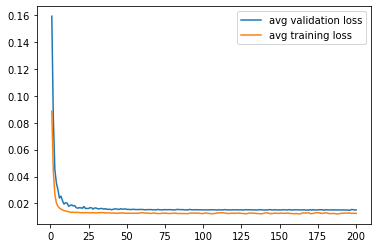

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,82.489055,79.17474,73.951027,72.159746


In [28]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 200, 5)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 201), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 201), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

In [29]:
torch.__version__

'1.10.1'

Epoch 10 	 Train Loss:  {0.015000437753218594} Valid Loss:  {0.012313256040215492}
Epoch 20 	 Train Loss:  {0.015073561815149857} Valid Loss:  {0.01221839152276516}
Epoch 30 	 Train Loss:  {0.01502170137157946} Valid Loss:  {0.012591897509992123}
Epoch 40 	 Train Loss:  {0.014965334878952213} Valid Loss:  {0.01260360423475504}
Epoch 50 	 Train Loss:  {0.015021580920526476} Valid Loss:  {0.012582563795149326}
Epoch 60 	 Train Loss:  {0.01500758726262685} Valid Loss:  {0.012276440858840942}
Epoch 70 	 Train Loss:  {0.0149849479114919} Valid Loss:  {0.012622183188796043}
Epoch 80 	 Train Loss:  {0.01509306032323476} Valid Loss:  {0.012836821377277374}
Epoch 90 	 Train Loss:  {0.014958257786929607} Valid Loss:  {0.012351948767900467}
Epoch 100 	 Train Loss:  {0.015101136639714241} Valid Loss:  {0.012372645549476147}


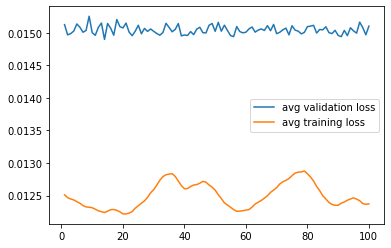

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,78.877674,79.031497,71.885731,71.536334


In [30]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

In [31]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg training loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg validation loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

TypeError: train_model() missing 1 required positional argument: 'batch_size'

In [ ]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg training loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg validation loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)